# Predicting Customer Satisfaction for Santander Bank


## Getting and Exploring the Data

In [1]:
# We first import all necessary libraries
import pandas as pd
import numpy as np
#from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, MaxAbsScaler, Normalizer
from sklearn.decomposition import PCA

from xgboost.sklearn import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier

from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectFromModel, SelectPercentile, f_classif, chi2
from sklearn.cross_validation import train_test_split, StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import f1_score, roc_auc_score, auc, make_scorer

# Make matplotlib show our plots inline
%matplotlib inline
# Set figure size
from pylab import rcParams
rcParams['figure.figsize'] = 12, 8

In [2]:
# Next let's load the data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
# Explore the data
print "The train dataset has {} rows, {} columns".format(*train.shape)
print "\nThe test dataset has {} rows, {} columns".format(*test.shape)
print "\nThe first 5 rows of the train set:\n{}".format(train.head())

The train dataset has 76020 rows, 371 columns

The test dataset has 75818 rows, 370 columns

The first 5 rows of the train set:
   ID  var3  var15  imp_ent_var16_ult1  imp_op_var39_comer_ult1  \
0   1     2     23                 0.0                      0.0   
1   3     2     34                 0.0                      0.0   
2   4     2     23                 0.0                      0.0   
3   8     2     37                 0.0                    195.0   
4  10     2     39                 0.0                      0.0   

   imp_op_var39_comer_ult3  imp_op_var40_comer_ult1  imp_op_var40_comer_ult3  \
0                      0.0                      0.0                      0.0   
1                      0.0                      0.0                      0.0   
2                      0.0                      0.0                      0.0   
3                    195.0                      0.0                      0.0   
4                      0.0                      0.0                  

In [3]:
# Find percentage of the unsatisfied class
percent_unsatisfied = train['TARGET'].mean()
print "The percentage of unsatisfied customers is: {:.2%}".format(percent_unsatisfied)

The percentage of unsatisfied customers is: 3.96%


In [4]:
# Summary stats about the train set
train.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


In [5]:
# Number of null values
print "The total number of null values is {}.".format(train.isnull().sum().sum())

# Find out the column data types that are not int or float
lst = train.dtypes.tolist()
non_num_lst = [i for i in lst if i not in ('int64', 'float64')]
if non_num_lst == []:
    print "All the column types are numerical."
else:
    print "The non numerical column data types are: {}".format(non_num_lst)

The total number of null values is 0.
All the column types are numerical.


In [6]:
# Separate feature, target columns and remove the ID column
y = train['TARGET'].copy()
X = train.drop(['ID', 'TARGET'], axis=1, inplace=False)

# Remove the test set's ID column too
test_id = test['ID'].copy()
test.drop(['ID'], axis=1, inplace=True)

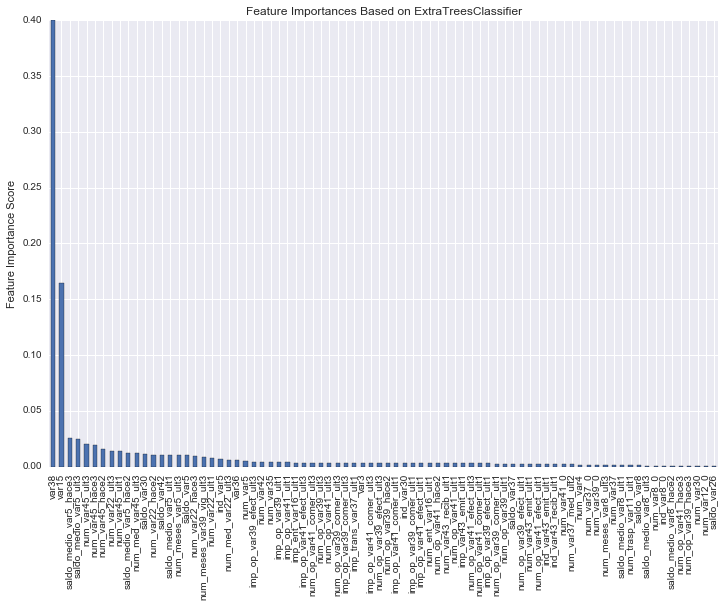

In [7]:
# Fit a classifier in order to find the feature importances
clf_fs = ExtraTreesClassifier(random_state=88)
clf_fs.fit(X, y)

# Plot the feature importances
ftr_imp = pd.Series(clf_fs.feature_importances_, index=X.columns.values).sort_values(ascending=False)
ftr_imp[:80].plot(kind='bar', title='Feature Importances Based on ExtraTreesClassifier')
plt.ylabel('Feature Importance Score')

var38 and var15 are the dominating features, take a closer look at them:

In [8]:
# List the feature importance values
print(ftr_imp)

var38                            0.399929
var15                            0.164683
saldo_medio_var5_hace3           0.025607
saldo_medio_var5_ult3            0.024721
num_var45_ult3                   0.020308
num_var45_hace3                  0.019343
num_var45_hace2                  0.015859
num_var22_ult3                   0.013722
num_var45_ult1                   0.013490
saldo_medio_var5_hace2           0.012389
num_med_var45_ult3               0.012160
saldo_var30                      0.011037
num_var22_hace2                  0.010738
saldo_var42                      0.010663
saldo_medio_var5_ult1            0.010456
num_meses_var5_ult3              0.010201
saldo_var5                       0.010103
num_var22_hace3                  0.009551
num_meses_var39_vig_ult3         0.008588
num_var22_ult1                   0.007931
ind_var5                         0.006370
num_med_var22_ult3               0.006307
var36                            0.006177
num_var5                         0

In [9]:
# Summary stats
print "var38's summary stats:"
print X.var38.describe()
print "\n"
print "var15's summary stats:"
print X.var15.describe()

var38's summary stats:
count    7.602000e+04
mean     1.172358e+05
std      1.826646e+05
min      5.163750e+03
25%      6.787061e+04
50%      1.064092e+05
75%      1.187563e+05
max      2.203474e+07
Name: var38, dtype: float64


var15's summary stats:
count    76020.000000
mean        33.212865
std         12.956486
min          5.000000
25%         23.000000
50%         28.000000
75%         40.000000
max        105.000000
Name: var15, dtype: float64


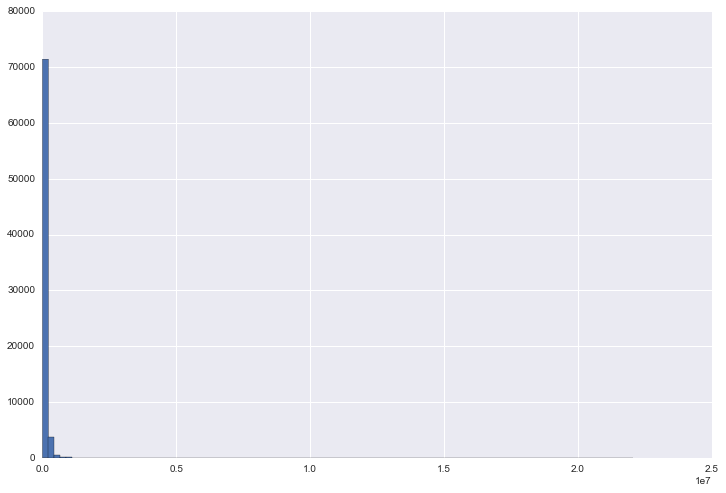

In [10]:
# var38's distribution
X.var38.hist(bins=100)

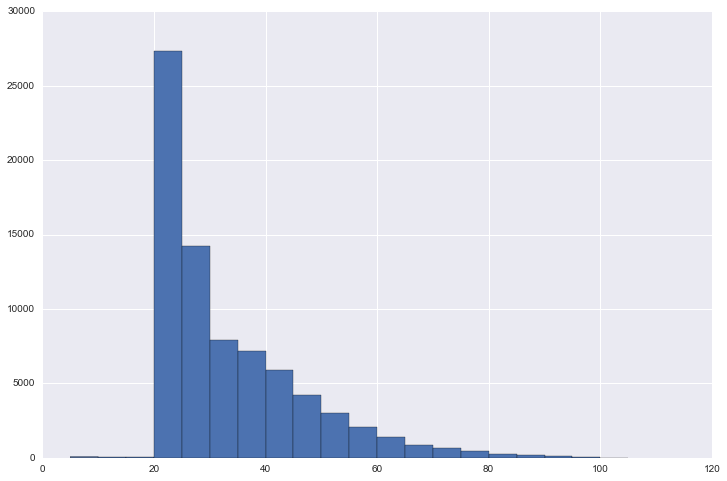

In [11]:
# var15's distribution
X.var15.hist(bins=20)

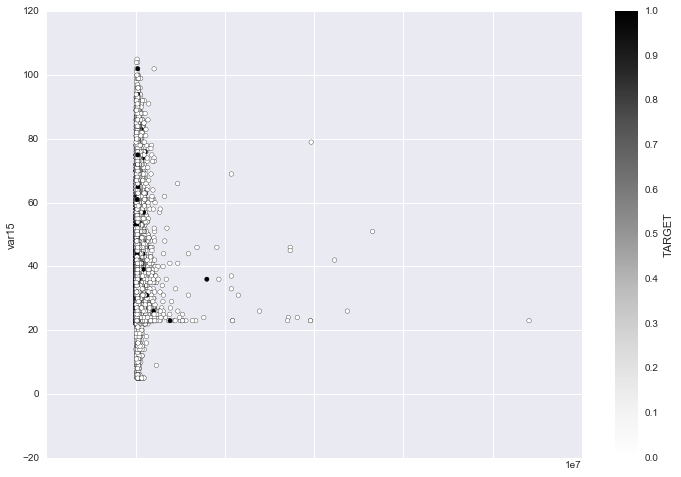

In [12]:
# Now plot the interaction between var38 and var15
train.plot(kind='scatter', x='var38', y='var15', c='TARGET')

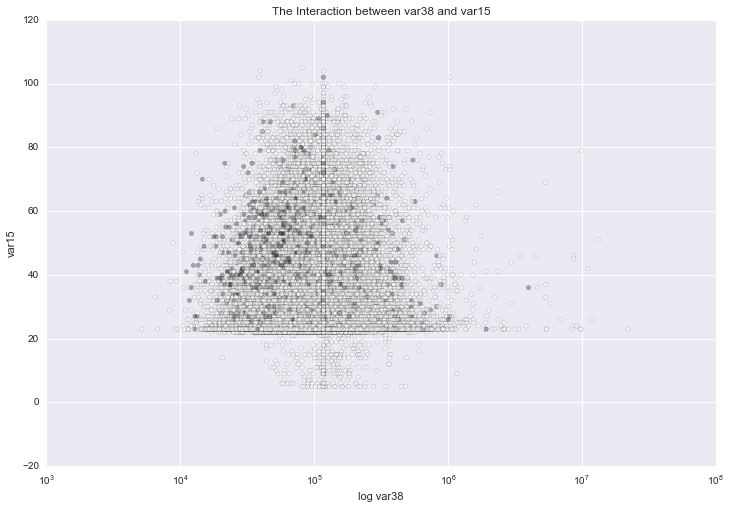

In [13]:
# Use log scale on x axis for better visulization
fig = plt.figure()
ax = plt.gca()
ax.scatter(x=train.var38,
           y=train.var15, 
           c=train.TARGET,
           alpha=0.3)
ax.set_xscale('log')
plt.xlabel('log var38')
plt.ylabel('var15')
plt.title('The Interaction between var38 and var15')

## Feature Preprocessing

In [14]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=.2, 
                                                    random_state=88, 
                                                    stratify=y)

The optimal number of PCA's is: 142


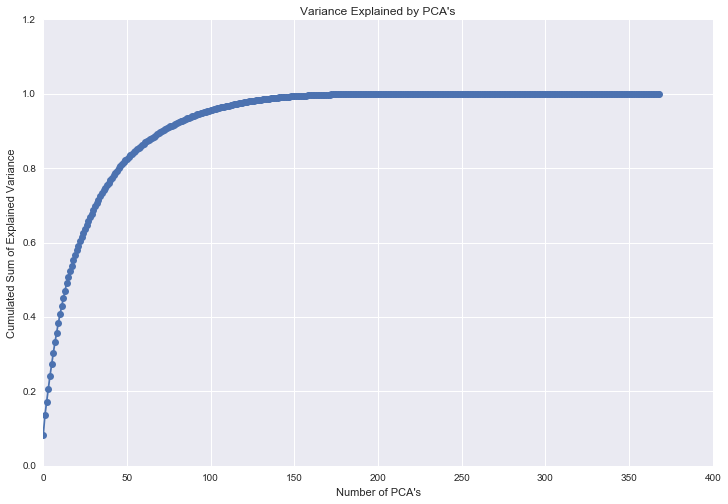

In [15]:
# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Find the optimal number of PCA 
pca = PCA(n_components=X_train_scaled.shape[1])
pca.fit(X_train_scaled)
ratios = pca.explained_variance_ratio_

# Plot the explained variance ratios
x = np.arange(X_train_scaled.shape[1])
plt.plot(x, np.cumsum(ratios), '-o')
plt.xlabel("Number of PCA's")
plt.ylabel("Cumulated Sum of Explained Variance")
plt.title("Variance Explained by PCA's")

# Find the optimal number of PCA's
for i in range(np.cumsum(ratios).shape[0]):
    if np.cumsum(ratios)[i] >= 0.99:
        num_pca = i + 1
        print "The optimal number of PCA's is: {}".format(num_pca)
        break
    else:
        continue

## Model Building and Testing

We build the model with GridSearchCV and pipeline, so that non only various data preprocessing can be integrated using a pipeline, but cross validation can be conducted as well.

In [19]:
# Remove all zero variance features
selector = VarianceThreshold()

# Choose the scaler
scale = StandardScaler() 
#scale = RobustScaler() 

# Choose the feature selection method
#ftr_sel = SelectPercentile()
ftr_sel = SelectFromModel(ExtraTreesClassifier(random_state=88))

# Choose the estimator
est = XGBClassifier()
#est = GaussianNB()
#est = LogisticRegression()
#est = RandomForestClassifier()
#est = AdaBoostClassifier()
#est = GradientBoostingClassifier()

# Prepare the pipeline
pipe = make_pipeline(#selector,
                     #scale,
                     #PCA(),
                     #ftr_sel,
                     est)

# Make the parameter grid
params = {
    #'pca__n_components': [num_pca],
    #'selectpercentile__score_func': [f_classif],
    #'selectpercentile__percentile': [10, 20, 30, 50, 60],
    #'selectfrommodel__threshold': ['mean', 'median'],
    #'selectkbest__k': [120, 130, 142],
    #'selectkbest__score_func': [f_classif], 
    #'logisticregression__random_state': [88],
    #'adaboostclassifier__n_estimators': [45],
    #'adaboostclassifier__learning_rate': [0.5],
    #'adaboostclassifier_n_estimators': [],
    #'randomforestclassifier__n_estimators': [10, 20],
    #'randomforestclassifier__max_features': ['auto', 'sqrt'],
    #'randomforestclassifier__random_state': [88], 
    #'adaboostclassifier__random_state': [88],
    #'gradientboostingclassifier__random_state': [88]
    'xgbclassifier__nthread': [4],
    #'xgbclassifier__objective': ['binary:logistic'],
    #'xgbclassifier__learning_rate': [0.1], 
    #'xgbclassifier__reg_lambda': [1], 
    #'xgbclassifier__max_depth': [4],
    #'xgbclassifier__min_child_weight': [4],
    'xgbclassifier__silent': [1],
    #'xgbclassifier__subsample': [1],
    #'xgbclassifier__colsample_bytree': [0.5],
    #'xgbclassifier__scale_pos_weight': [1],
    #'xgbclassifier__n_estimators': [100],
    'xgbclassifier__seed': [88]
}

# Make an StratifiedShuffleSplit iterator for cross-validation in GridSearchCV
#sss = StratifiedShuffleSplit(y_train, n_iter=10, test_size=.3, random_state=88)

# Make the model using GridSearchCV and run cross-validation
clf = GridSearchCV(pipe,
                   param_grid=params,
                   scoring='roc_auc',
                   #cv=sss,
                   n_jobs=4,
                   verbose=1)

# Fit the model using premade clf
clf.fit(X_train, y_train)
# Calculate the AUC score
print "The AUC score is: {}".format(roc_auc_score(y_test, 
                                                  clf.predict_proba(X_test)[:,1], 
                                                  average='macro'))

Fitting 3 folds for each of 1 candidates, totalling 3 fits
The AUC score is: 0.838048399141


[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:   18.2s finished


In [17]:
#0.842057031736
#clf.best_estimator_.named_steps['selectfrommodel']
#clf.best_estimator_.named_steps['xgbclassifier']
clf.best_estimator_

Pipeline(steps=[('xgbclassifier', XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.5,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=4, missing=None, n_estimators=100, nthread=4,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=88, silent=1, subsample=1))])

In [18]:
# Submission
probs = clf.predict_proba(test)
submission = pd.DataFrame({"ID": test_id, "TARGET": probs[:,1]})
submission.to_csv("submission_0.842057031736_xgb.csv", index=False)